In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, WeightedRandomSampler
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import os

In [2]:
# -----------------------
# CONFIG
# -----------------------
pulse_samples = 1000     # n_feat_muon
n_feat_frec = 2500       # n_feat_frec
batch_size = 256
epochs = 80
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 21

# Paths a tus datasets
muon_dataset_path = "muon_dataset_segmented_v3.npz"
simulated_npz_path = "Espectros/spectrum_simulated.npz"
real_npz_path = "Espectros/spectrum_real.npz"

print("Device:", device)



# -----------------------
# CARGA DE DATASET DE MUONES
# -----------------------
data = np.load(muon_dataset_path)
X_muones = data['X']        # shape (num_pulsos, pulse_samples)
y_muones = data['y']        # shape (num_pulsos,)

# -----------------------
# Normalizar pulsos de muones al mismo rango
# -----------------------
# Tomar el máximo global de todos los pulsos
max_global = X_muones.max()

# Escalar todos los pulsos para que el pulso con mayor valor llegue a 1
X_muones = X_muones / (max_global + 1e-8)  # evitar división por cero

# Convertir a tensores PyTorch
X_muones = torch.tensor(X_muones, dtype=torch.float32).unsqueeze(1)  # (N,1,pulse_samples)
y_muones = torch.tensor(y_muones, dtype=torch.long).squeeze()         # (N,)

print(f"Señales de muones: {X_muones.shape}, targets: {y_muones.shape}")





# -----------------------
# CARGA DE ESPECTROS
# -----------------------
def load_npz(path):
    data = np.load(path)
    freq = data['freq']
    att = data['attenuation_db']
    return torch.tensor(freq, dtype=torch.float32), torch.tensor(att, dtype=torch.float32)

sim_freq, H_sim = load_npz(simulated_npz_path)
real_freq, H_real = load_npz(real_npz_path)

# -----------------------
# Normalizar espectros simulados H_sim de 0 a 1
# -----------------------
H_sim_min = H_sim.min()
H_sim_max = H_sim.max()
H_sim_norm = (H_sim - H_sim_min) / (H_sim_max - H_sim_min + 1e-8)  # evitar división por cero

# Repetir para cada ejemplo
H_sim_batch = H_sim_norm.repeat(X_muones.shape[0], 1)  # (N, n_feat_frec)

Device: cuda
Señales de muones: torch.Size([10000, 1, 1000]), targets: torch.Size([10000])


In [3]:
# -----------------------
# DEFINICIÓN DE LA RED
# -----------------------
class TwoBranchNet(nn.Module):
    def __init__(self, n_feat_muon=1000, n_feat_frec=2500, n_classes=21):
        super(TwoBranchNet, self).__init__()
        
        # --- Rama CNN Muones ---
        self.cnn_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),         
            nn.MaxPool1d(2),
            

            nn.Conv1d(128, 256, kernel_size=5, padding='same'),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(1),  # (batch, 256, 1)
            nn.Flatten()
        )
        
        # Rama 2: Respuesta en frecuencia simulada (MLP)
        self.mlp_branch = nn.Sequential(
            nn.Linear(n_feat_frec, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )

        # --- Cabezal de fusión ---
        self.head = nn.Sequential(
            nn.Linear(256 + 32, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x_muon, x_freq):
        v1 = self.cnn_branch(x_muon)
        v1 = v1.view(v1.size(0), -1)
        v2 = self.mlp_branch(x_freq)
        merged = torch.cat([v1, v2], dim=1)
        out = self.head(merged)
        return out

# -----------------------
# Inicializar modelo
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)
summary(model, input_size=[(1,1,1000), (1,2500)])

Layer (type:depth-idx)                   Output Shape              Param #
TwoBranchNet                             [1, 21]                   --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Conv1d: 2-1                       [1, 64, 1000]             1,024
│    └─BatchNorm1d: 2-2                  [1, 64, 1000]             128
│    └─LeakyReLU: 2-3                    [1, 64, 1000]             --
│    └─MaxPool1d: 2-4                    [1, 64, 500]              --
│    └─Conv1d: 2-5                       [1, 128, 500]             57,472
│    └─BatchNorm1d: 2-6                  [1, 128, 500]             256
│    └─LeakyReLU: 2-7                    [1, 128, 500]             --
│    └─MaxPool1d: 2-8                    [1, 128, 250]             --
│    └─Conv1d: 2-9                       [1, 256, 250]             164,096
│    └─BatchNorm1d: 2-10                 [1, 256, 250]             512
│    └─LeakyReLU: 2-11                   [1, 256, 250]             --


Conteo por clase: [18, 11, 21, 74, 271, 939, 2078, 2151, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pesos por clase: [0.0555555559694767, 0.09090909361839294, 0.0476190485060215, 0.013513513840734959, 0.0036900369450449944, 0.0010649627074599266, 0.0004812319530174136, 0.00046490004751831293, 0.027027027681469917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Train size: 5600, Val size: 2400, Test size: 2000

Verificando balanceo de batches...

Batch 0 (256 samples):
  Clase 0: 31 samples (12.1%)
  Clase 1: 32 samples (12.5%)
  Clase 2: 27 samples (10.5%)
  Clase 3: 28 samples (10.9%)
  Clase 4: 22 samples (8.6%)
  Clase 5: 26 samples (10.2%)
  Clase 6: 28 samples (10.9%)
  Clase 7: 30 samples (11.7%)
  Clase 8: 32 samples (12.5%)

Batch 1 (256 samples):
  Clase 0: 34 samples (13.3%)
  Clase 1: 38 samples (14.8%)
  Clase 2: 27 samples (10.5%)
  Clase 3: 32 samples (12.5%)
  Clase 4: 24 samples (9.4%)
  Clase 5: 24 samples (9.4%)
  Clase 6: 24 samples (9.4%)
  Clase 7: 31 sam

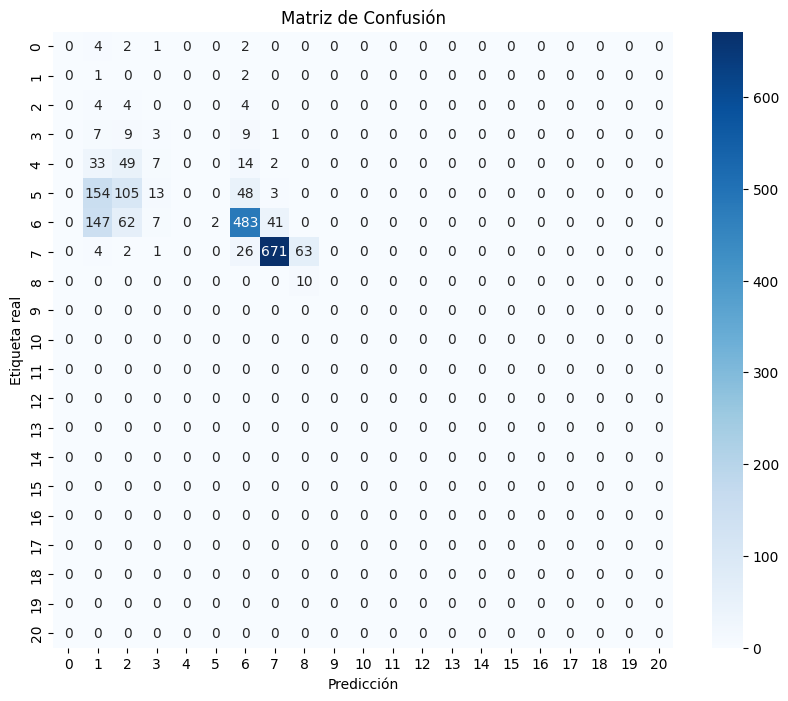


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.0028    0.3333    0.0056         3
           2     0.0172    0.3333    0.0327        12
           3     0.0938    0.1034    0.0984        29
           4     0.0000    0.0000    0.0000       105
           5     0.0000    0.0000    0.0000       323
           6     0.8214    0.6509    0.7263       742
           7     0.9345    0.8748    0.9037       767
           8     0.1370    1.0000    0.2410        10

    accuracy                         0.5860      2000
   macro avg     0.2230    0.3662    0.2231      2000
weighted avg     0.6653    0.5860    0.6189      2000



C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

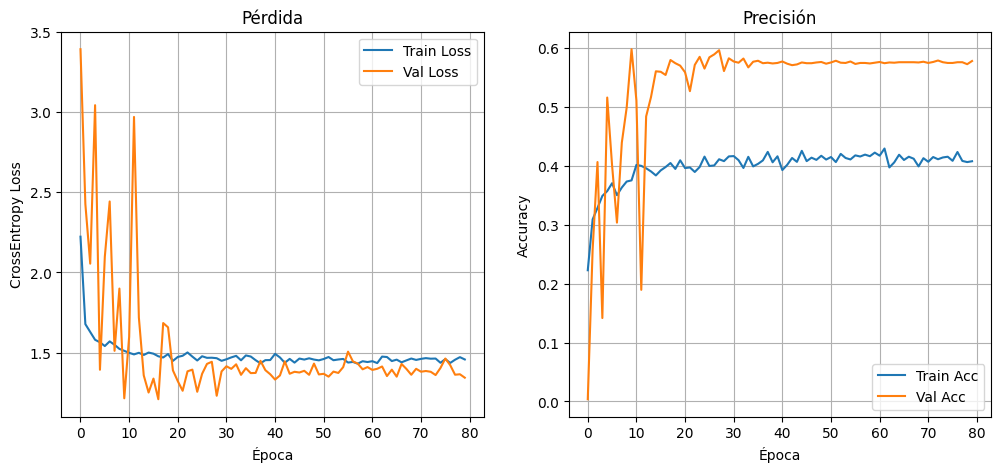

In [4]:
# -----------------------
# Datasets y DataLoaders
# -----------------------

dataset = TensorDataset(X_muones, H_sim_batch, y_muones)

# Primer split: Train+Val vs Test (80/20)
n_total = len(dataset)
n_trainval = int(0.8 * n_total)
n_test = n_total - n_trainval
trainval_dataset, test_dataset = random_split(dataset, [n_trainval, n_test])

# Segundo split: Train vs Val (70/30 del 80%)
n_train = int(0.7 * n_trainval)
n_val  = n_trainval - n_train
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val])



# Obtener las etiquetas de tu dataset de entrenamiento
all_labels = []
for i in range(len(train_dataset)):
    _, _, label = train_dataset[i]
    all_labels.append(label)

all_labels = torch.tensor(all_labels)

# Calcular el peso para cada clase
class_counts = torch.bincount(all_labels, minlength=n_classes)
class_weights = 1.0 / class_counts.float()
class_weights[class_weights == float('inf')] = 0  # Manejar clases con 0 muestras

print("Conteo por clase:", class_counts.tolist())
print("Pesos por clase:", class_weights.tolist())

# Asignar a cada muestra el peso de su clase
sample_weights = [class_weights[label] for label in all_labels]



# Crear el WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Número de muestras a muestrear por época
    replacement=True  # IMPORTANTE: Permitir muestreo con reemplazo para clases minoritarias
)

# DataLoader de entrenamiento con el sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=weighted_sampler,  # Usar el sampler ponderado
    num_workers=4
)

# Val y Test se mantienen igual (sin sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


def check_sampler_balance(loader, n_classes, num_batches=3):
    """Verifica que el sampler esté balanceando correctamente"""
    print("\nVerificando balanceo de batches...")
    
    for batch_idx, (x_muon, x_freq, y) in enumerate(loader):
        if batch_idx >= num_batches:
            break
        
        class_counts = torch.bincount(y, minlength=n_classes)
        total_samples = len(y)
        
        print(f"\nBatch {batch_idx} ({total_samples} samples):")
        for class_id in range(n_classes):
            count = class_counts[class_id].item()
            if count > 0:
                percentage = (count / total_samples) * 100
                print(f"  Clase {class_id}: {count} samples ({percentage:.1f}%)")

# Verificar el balanceo
check_sampler_balance(train_loader, n_classes, num_batches=3)



# -----------------------
# Inicialización de modelo, optimizer y scheduler
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)








# -----------------------
# Custom Loss: CrossEntropy + Penalización de cero
# -----------------------
def custom_loss_distance(outputs, targets, min_prob=0.05, alpha=100.0):
    """
    CrossEntropy + penalización más fuerte para clases presentes con baja fracción de predicción.
    Penalización decrece suavemente si la fracción aumenta.
    
    min_prob: fracción mínima esperada de predicciones por clase presente
    alpha: escala de penalización
    """
    ce = nn.CrossEntropyLoss()(outputs, targets)
    
    probs = torch.softmax(outputs, dim=1)
    present_classes = torch.unique(targets)

    penalty = 0.0
    for c in present_classes:
        pred_fraction = (probs.argmax(dim=1) == c).float().mean()

        # Diferencia respecto al mínimo
        diff = torch.relu(min_prob - pred_fraction)

        # Penalización cuadrática -> más fuerte si está muy cerca de 0
        penalty += diff ** 2  
    
    penalty = penalty / len(present_classes)
    return ce + alpha * penalty


def custom_loss_strong(outputs, targets, min_prob=0.05, alpha=100.0): 
    """ 
    CrossEntropy + penalización fuerte si alguna clase presente no se predice. 
    min_prob: probabilidad mínima que queremos para cada clase presente
    """ 
    ce = nn.CrossEntropyLoss()(outputs, targets) 

    probs = torch.softmax(outputs, dim=1) 
    batch_size = targets.size(0) 
    present_classes = torch.unique(targets) 

    penalty = 0.0 
    for c in present_classes: # fracción de ejemplos predichos como c 
        pred_fraction = (probs.argmax(dim=1) == c).float().mean() # penalizamos si pred_fraction < min_prob 

        penalty += torch.relu(min_prob - pred_fraction) # promedio sobre las clases presentes 

        penalty = penalty / len(present_classes) 
        
    return ce + alpha * penalty # multiplicador fuerte


# Definir una función de pérdida combinada
def custom_loss_combined(outputs, targets, class_weights, min_prob=0.05, alpha=0):
    """
    Combina CrossEntropyLoss ponderada con la penalización de fracción de predicción.
    """
    # Entropía cruzada ponderada
    ce_loss = nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

    # Tu penalización personalizada (sin cambios)
    probs = torch.softmax(outputs, dim=1)
    present_classes = torch.unique(targets)
    
    penalty = 0.0
    for c in present_classes:
        pred_fraction = (probs.argmax(dim=1) == c).float().mean()
        penalty += torch.relu(min_prob - pred_fraction)

    penalty = penalty / len(present_classes)
    
    return ce_loss + alpha * penalty





# -----------------------
# Entrenamiento
# -----------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for x_muon_batch, x_freq_batch, y_batch in train_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_muon_batch, x_freq_batch)
        loss = custom_loss_strong(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_muon_batch.size(0)
        preds = output.argmax(dim=1)
        running_corrects += (preds == y_batch).sum().item()

    epoch_loss = running_loss / n_train
    epoch_acc  = running_corrects / n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for x_muon_batch, x_freq_batch, y_batch in val_loader:
            x_muon_batch = x_muon_batch.to(device)
            x_freq_batch = x_freq_batch.to(device)
            y_batch = y_batch.to(device)

            val_output = model(x_muon_batch, x_freq_batch)
            val_loss = custom_loss_strong(val_output, y_batch)

            val_running_loss += val_loss.item() * x_muon_batch.size(0)
            preds = val_output.argmax(dim=1)
            val_running_corrects += (preds == y_batch).sum().item()

    val_epoch_loss = val_running_loss / n_val
    val_epoch_acc  = val_running_corrects / n_val
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    scheduler.step(val_epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

# -----------------------
# Guardar pesos
# -----------------------
os.makedirs("model_weights", exist_ok=True)
torch.save(model.state_dict(), "model_weights/two_branch_net.pth")
print("Pesos guardados en 'model_weights/two_branch_net.pth'")

# -----------------------
# Evaluación y métricas
# -----------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in test_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_muon_batch, x_freq_batch)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, labels=list(range(n_classes)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(all_labels, all_preds, digits=4))

# -----------------------
# Plot de pérdida y accuracy
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("CrossEntropy Loss")
plt.title("Pérdida")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión")
plt.grid(True)
plt.legend()
plt.show()

Accuracy en Test: 58.60%


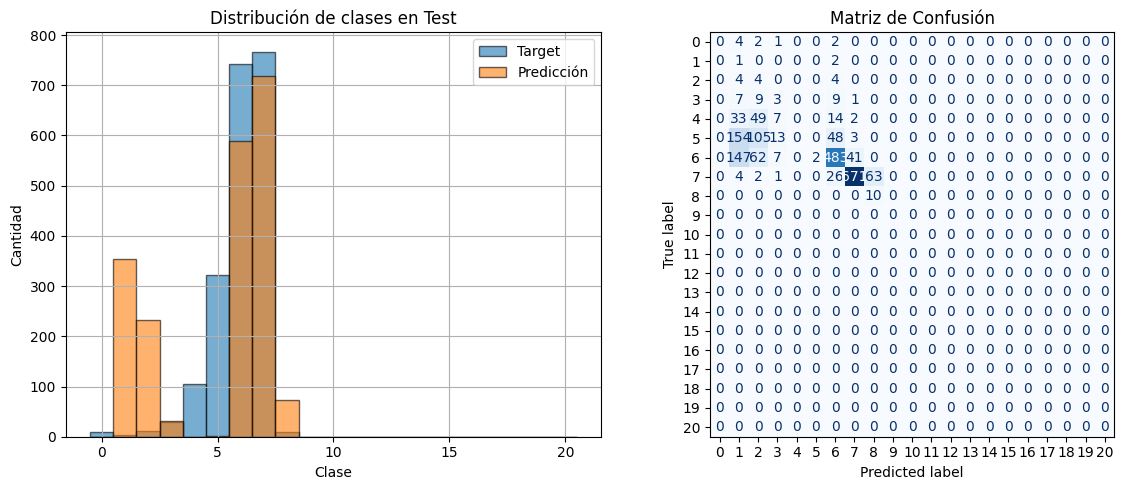

In [5]:
# -----------------------
# Evaluación en Test
# -----------------------
model.eval()
test_preds_all = []
test_targets_all = []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in test_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        test_output = model(x_muon_batch, x_freq_batch)
        preds = test_output.argmax(dim=1)   # <- argmax para clases
        test_preds_all.append(preds.cpu())
        test_targets_all.append(y_batch.cpu())

# Concatenar todos los batches
test_preds_all = torch.cat(test_preds_all)
test_targets_all = torch.cat(test_targets_all)

# Accuracy
acc_test = accuracy_score(test_targets_all.numpy(), test_preds_all.numpy())
print(f"Accuracy en Test: {acc_test*100:.2f}%")

# Histograma de clases predichas vs reales
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(test_targets_all.numpy(), bins=np.arange(-0.5, 21.5, 1), alpha=0.6, label="Target", edgecolor='k')
plt.hist(test_preds_all.numpy(), bins=np.arange(-0.5, 21.5, 1), alpha=0.6, label="Predicción", edgecolor='k')
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.title("Distribución de clases en Test")
plt.legend()
plt.grid(True)

# Matriz de confusión
plt.subplot(1,2,2)
cm = confusion_matrix(test_targets_all.numpy(), test_preds_all.numpy(), labels=np.arange(21))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(21))
disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()
